# Semantic Vector Search

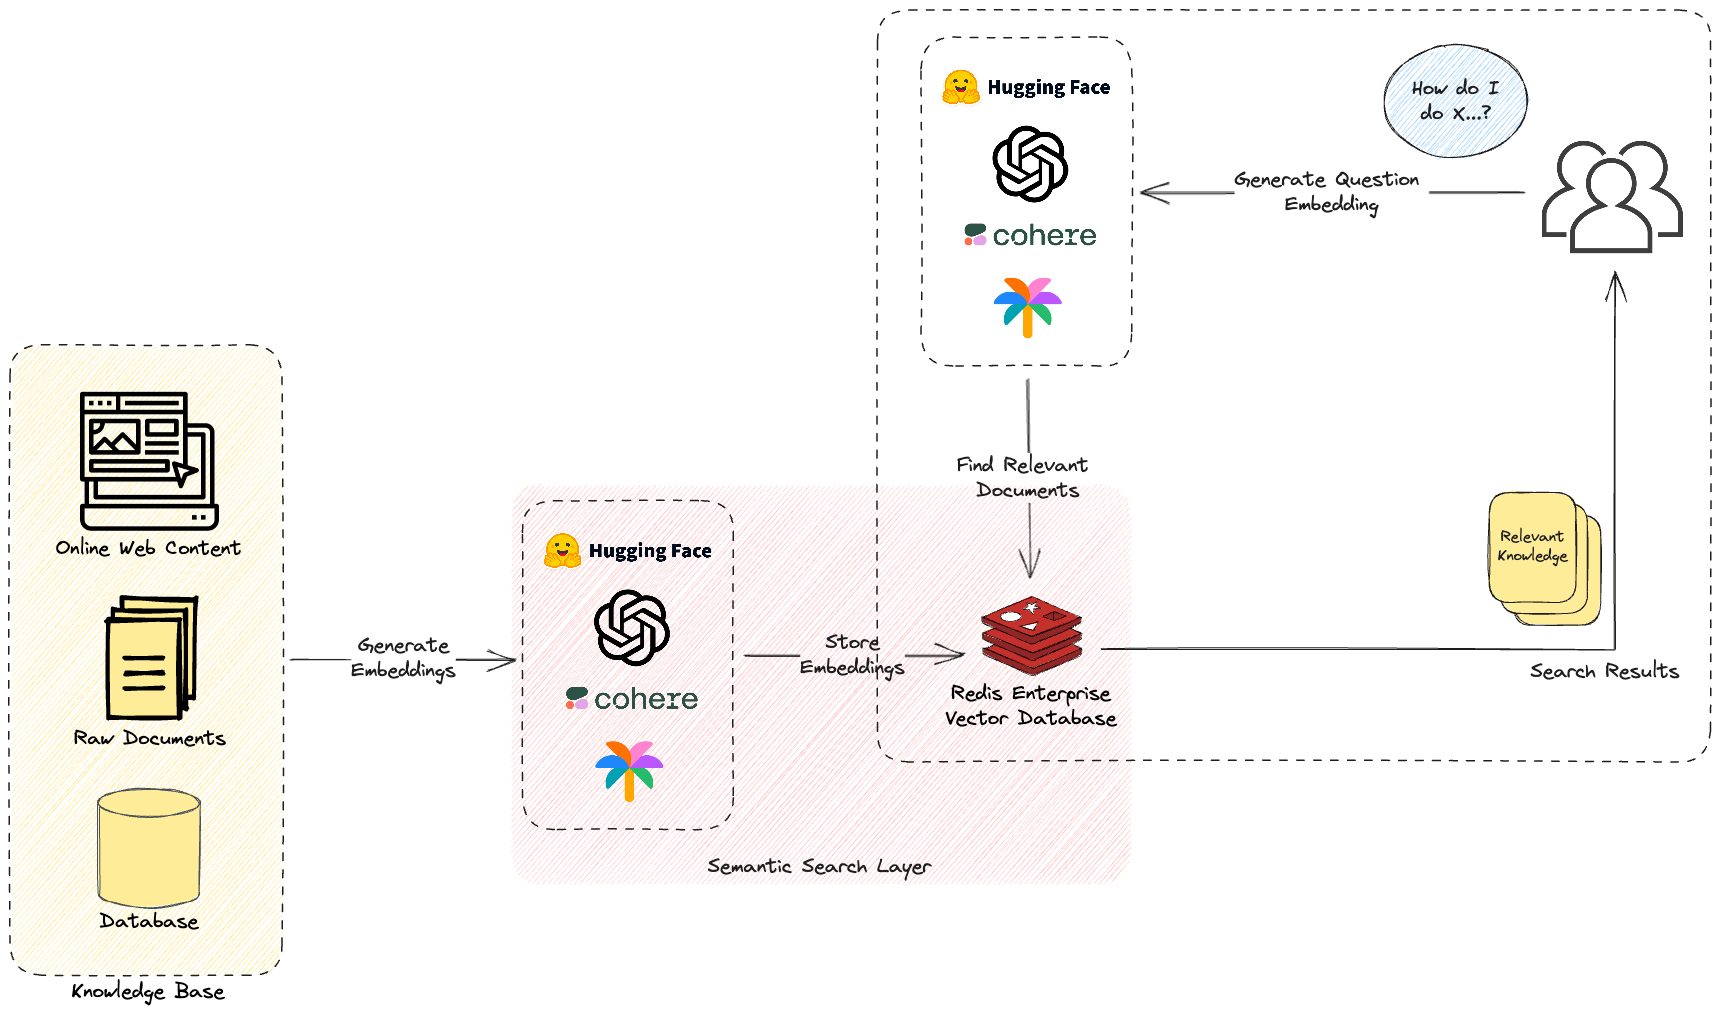

## 0. Prerequisites
Before we begin, we must install the required libraries.

In [ ]:
!pip install sentence-transformers redis redisvl gradio

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Install Redis locally (optional)
If you have a Redis db running elsewhere with [Redis Stack](https://redis.io/docs/about/about-stack/) installed, you don't need to run it on this machine. You can skip to the "Connect to Redis server" step.

You can install Redis-Stack locally using the following block:

In [3]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


In [4]:
# Redis connection params
redis_url = "redis://127.0.0.1:6379"

### Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [14]:
# Redis connection params
redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

In [5]:
import redis

# Create Redis client
redis_client = redis.from_url(redis_url)

# Test connection
redis_client.ping()

True

In [6]:
# Clear Redis database (optional)
redis_client.flushdb()

True

### Load Working Files from Github

In [8]:
#Load working files from git repository
!npx degit aelkouhen/redis-vss/ColabDrive -f

npx: installed 1 in 0.908s
> destination directory is not empty. Using --force, continuing
> cloned aelkouhen/redis-vss#HEAD


### Mount Google Drive (Optional)

Optionally, you can load the working files from Google Drive.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare Knowledge Base

Execute the scarping script that loads Redis Blog Posts

In [9]:
!python extract_redis_blog.py

Retrieving blogs after 2023-08-01T00:00:00+00:00
Processing post URL : https://redis.com/blog/velocity-based-data-architectures/
Processing post URL : 
https://redis.com/blog/choose-microservice-monitoring-tool/
Processing post URL : https://redis.com/blog/jedis-vs-lettuce-an-exploration/
Processing post URL : https://redis.com/blog/introducing-triggers-and-functions/
Processing post URL : 
https://redis.com/blog/implementing-designing-microservices/
Processing post URL : 
https://redis.com/blog/redis-enterprise-7-2-brings-exciting-innovations-that-ope
rators-will-love/
Processing post URL : https://redis.com/blog/introducing-auto-tiering/
Processing post URL : https://redis.com/blog/introducing-redis-data-integration/
Processing post URL : https://redis.com/blog/five-official-redis-clients/
Processing post URL : 
https://redis.com/blog/understanding-redis-for-cloud-and-multicloud-in-90-second
s/
Processing post URL : 
https://redis.com/blog/lowering-costs-with-redis-enterprise-in-90-s

## 1. Vector Storage & Indexing

A. Load the Text Vectorizer `all-mpnet-base-v2` from HuggingFace.

In [10]:
from redisvl.vectorize.text import HFTextVectorizer
vectorizer = HFTextVectorizer(model="sentence-transformers/all-mpnet-base-v2")

C. Fetch the generated dataset from the Drive that contains the Redis Blog Posts and create embeddings for each post.

In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv("docs/csv/redis_blogs.csv")
concatenated_values = df[['title', 'author', 'date', 'text']].astype(str).apply('; '.join, axis=1)
df['concatenated_column'] = concatenated_values
df['emb'] = vectorizer.embed_many(df['concatenated_column'].tolist(), as_buffer=True)

C. Create a Redis secondary index (using a YAML definition) to query vectors.


In [12]:
from redisvl.index import AsyncSearchIndex

index = AsyncSearchIndex.from_yaml('index.yaml')
index.connect(redis_url)
await index.create(overwrite=True)

C'. Create a Redis secondary index (using RediSearch Command) to query vectors.

or with the following command:

In [13]:
# Drop the index
redis_client.execute_command("FT.drop blogs_idx")
# Create the index
redis_client.execute_command("FT.create blogs_idx ON HASH PREFIX 1 post: SCHEMA author as author TAG title AS title TEXT url AS url TEXT text AS text TEXT date as date TEXT emb as emb VECTOR FLAT 6 DIM 768 DISTANCE_METRIC COSINE TYPE FLOAT32")

b'OK'

D. Load embeddings into Redis

In [14]:
await index.load(df.to_dict(orient="records"))

## 2. Vector Querying

We define a helper function, `ask_llm`, that invokes the transformer wrapped with a cache check.


In [15]:
from redisvl.query import VectorQuery
from redisvl.llmcache.semantic import SemanticCache

async def ask_llm(query_string:str):
  cache = SemanticCache(redis_url=redis_url, threshold=0.7)
  cached_result = cache.check(prompt=query_string)

  if cached_result:
      print("Retrieving cached response...\n")
      full_response = cached_result[0]
  else:
      query_embedding = vectorizer.embed(query_string)
      query = VectorQuery(vector=query_embedding, vector_field_name='emb', return_fields=["url", "title", "date", "author", "text"], num_results=3)
      results = await index.search(query.query, query_params=query.params)
      responses = []

      for doc in results.docs:
          responses.append([doc.title, doc.date, doc.author, doc.url, doc.text])

      full_response = "You can find the answer to your question in the following resources:\n"

      for response in responses:
          title, date, author, url, text = response
          full_response += u"\U0001F449"
          full_response += f""" Blog Title: {title}\n{author}, {date}\n{url}\n"""

      cache.store(query_string, full_response)
  return full_response

In [16]:
%%time
import asyncio
import nest_asyncio

# Enable nested asyncio event loop
nest_asyncio.apply()

# Schedule the coroutine to run in the event loop
response = asyncio.run(ask_llm(query_string = "What is data defense?"))
print(response)

You can find the answer to your question in the following resources:
👉 Blog Title: The Elements of a Data Strategy
Amine El Kouhen, July 20, 2023
https://redis.com/blog/elements-of-a-data-strategy/
👉 Blog Title: Data 101: The Fundamentals of Data Science
Amine El Kouhen, July 10, 2023
https://redis.com/blog/data-101-data-science-fundamentals/
👉 Blog Title: An Introduction to Velocity-Based Data Architectures
Amine El Kouhen, August 7, 2023
https://redis.com/blog/velocity-based-data-architectures/

CPU times: user 233 ms, sys: 961 µs, total: 234 ms
Wall time: 241 ms


## 3. Semantic Cache

Let's check the response time for a second invocation of this query.

In [17]:
%%time

# Enable nested asyncio event loop
nest_asyncio.apply()

# Schedule the coroutine to run for the second time in the event loop
response = asyncio.run(ask_llm(query_string = "Could you explain data defense"))
print(response)

Retrieving cached response...

You can find the answer to your question in the following resources:
👉 Blog Title: The Elements of a Data Strategy
Amine El Kouhen, July 20, 2023
https://redis.com/blog/elements-of-a-data-strategy/
👉 Blog Title: Data 101: The Fundamentals of Data Science
Amine El Kouhen, July 10, 2023
https://redis.com/blog/data-101-data-science-fundamentals/
👉 Blog Title: An Introduction to Velocity-Based Data Architectures
Amine El Kouhen, August 7, 2023
https://redis.com/blog/velocity-based-data-architectures/

CPU times: user 107 ms, sys: 859 µs, total: 108 ms
Wall time: 115 ms


# 3. User Interface



In [ ]:
import gradio as gr

def clear_memory():
    redis_client.delete('chat-history')

def respond(query, chat_history):
    result  = asyncio.run(ask_llm(query))
    chat_history.append((query, result))
    return "", chat_history

with gr.Blocks() as demo:
    nest_asyncio.apply()
    chatbot = gr.Chatbot(height=240)
    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")
    clearMemoryBtn = gr.Button("Clear Memory")
    clearMemoryBtn.click(clear_memory)
    btn.click(respond, [msg, chatbot], [msg, chatbot])
    msg.submit(respond, [msg, chatbot], [msg, chatbot]) #Press enter to submit

gr.close_all()
demo.launch(debug=True)